In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflo

In [2]:
base = pd.read_csv("petr4-treinamento.csv")
base = base.dropna()

In [3]:
base_treinamento = base.iloc[:, 1:7].values

In [4]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [5]:
previsores = []
preco_real = []

#Muda ali em 0:6, pq agora são mais previsores
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 0])


In [6]:
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [7]:
previsores.shape

(1152, 90, 6)

In [8]:
preco_real.shape

(1152,)

In [9]:
# A linha abaixo nós podemos excluir pois ela já está no formato correto conforme o shape acima '(1152,90,6)'

# previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [10]:
regressor = Sequential()

# Agora são 6 atributos previsores, muda para 6 no final da linha
regressor.add(LSTM(units = 100, return_sequences = True, input_shape =(previsores.shape[1], 6) ))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))


regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# Vamos fazer um teste diferente, ao invés de usar 'linear' vamos usar 'sigmoid', devido a normalização entre 0 e 1
regressor.add(Dense(units = 1, activation = 'sigmoid'))

In [11]:
# muda o otimizador para o 'adam'.
# E nesse trecho vamos criar umas classes diferentes conforme importado acima
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                         metrics = ['mean_absolute_error'])

### Callbacks: É um conjunto de funções que pode ser aplicado em determinados estados do processo de treinamento. Pode ser usado para ter uma visão interna dos estados e estatisticas do modelo durante o treinamento. 



###### EarlyStopping:   Vai parar de fazer o treinamento quando uma quantidade/função monitorada parou de melhor.  Exemplo: suponde que se está usando uma loss function que pode ser o mean_squared_error durante 20, 30 repetições da atualização dos pesos parou de melhorar os resultados. 

###### ARGUMENTOS:
   ###### monitor: quantidade/função a ser monitorada (loss function)
   ###### min_delta: Mudança minima que deve ser monitorada para ser considerada melhoria.
   ###### patience:  número de épocas que irá seguir sem melhorias no resultado, se ele passar esse número de épocas irá parar o treinamento. Exemplo: Se passar 10 épocas sem melhorar, como é colocado abaixo, ele para o treinamento. É uma especie de tolerância.
   ##### Verbose: Só serve para mandar algumas mensagens na tela.

In [12]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)

###### ReduceLROnPlateau: Reduzir a taxa de aprendizagem(learning rate) quando uma métrica parou de melhorar. 

###### ARGUMENTOS

###### monitor: quantidade/função a ser monitorada (loss function).

###### min_delta: Mudança minima que deve ser monitorada para ser considerada melhoria.

###### patience: número de épocas que irá seguir sem melhorias no resultado, se ele passar esse número de épocas irá parar o treinamento. Exemplo: Se passar 10 épocas sem melhorar, como é colocado abaixo, ele entra em ação.

###### factor: valor que a learning rate seŕa reduzida, ou seja, valor que irá multiplicar a lr pelo factor, ficando a relação "new_lr  =  lr * factor".


In [13]:
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, epochs = 5, verbose = 1)

###### ModelCheckpoint: Vai salvar o modelo depois de cada época. Vamos supor que é colocado para rodar 100 épocas, ele sempre vai salvar o modelo(pesos) e com isso se vai conseguir no final  ter o melhor model caso queira desenvolve uma aplicação comercial. Antes nós havíamos utilizado o Cross Validation mas o Keras tem  alguns recursos interessantes para ele ir gravando os pesos assim que consegue os melhores resultados.

##### ARGUMENTOS

###### filepath: caminho do arquivo que irá salvar

###### monitor: quantidade/função a ser monitorada (loss function).

###### save_best_only: salvar sempre o que tiver melhor resultado

In [14]:
# h5 é o formato que irá ser armazenado. 
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', save_best_only = True, verbose = 1)

In [15]:
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32,
                 callbacks = [es,rlr,mcp])

W1105 19:49:39.427062 140031271401280 deprecation_wrapper.py:119] From /home/jarbasjr/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/100
1152/1152 [==============================] - 8s 7ms/step - loss: 0.0223 - mean_absolute_error: 0.1146

Epoch 00001: loss improved from inf to 0.02225, saving model to pesos.h5
Epoch 2/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0697

Epoch 00002: loss improved from 0.02225 to 0.00777, saving model to pesos.h5
Epoch 3/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.0058 - mean_absolute_error: 0.0599

Epoch 00003: loss improved from 0.00777 to 0.00582, saving model to pesos.h5
Epoch 4/100
1152/1152 [==============================] - 6s 6ms/step - loss: 0.0055 - mean_absolute_error: 0.0584

Epoch 00004: loss improved from 0.00582 to 0.00549, saving model to pesos.h5
Epoch 5/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0525

Epoch 00005: loss improved from 0.00549 to 0.00457, saving model to pesos.h5
Epoch 6/100
1152/1152 [=====================

1152/1152 [==============================] - 7s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0250

Epoch 00046: loss improved from 0.00116 to 0.00111, saving model to pesos.h5
Epoch 47/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0259

Epoch 00047: loss did not improve from 0.00111
Epoch 48/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0248

Epoch 00048: loss did not improve from 0.00111
Epoch 49/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0255

Epoch 00049: loss improved from 0.00111 to 0.00111, saving model to pesos.h5
Epoch 50/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0257

Epoch 00050: loss did not improve from 0.00111
Epoch 51/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0249

Epoch 00051: loss impr


Epoch 00091: loss did not improve from 0.00057
Epoch 92/100
1152/1152 [==============================] - 6s 5ms/step - loss: 6.2267e-04 - mean_absolute_error: 0.0181

Epoch 00092: loss did not improve from 0.00057
Epoch 93/100
1152/1152 [==============================] - 6s 6ms/step - loss: 6.0757e-04 - mean_absolute_error: 0.0176

Epoch 00093: loss did not improve from 0.00057
Epoch 94/100
1152/1152 [==============================] - 6s 6ms/step - loss: 6.5504e-04 - mean_absolute_error: 0.0180

Epoch 00094: loss did not improve from 0.00057
Epoch 95/100
1152/1152 [==============================] - 7s 6ms/step - loss: 6.3708e-04 - mean_absolute_error: 0.0179

Epoch 00095: loss did not improve from 0.00057
Epoch 96/100
1152/1152 [==============================] - 7s 6ms/step - loss: 6.3847e-04 - mean_absolute_error: 0.0182

Epoch 00096: loss did not improve from 0.00057
Epoch 97/100
1152/1152 [==============================] - 7s 6ms/step - loss: 5.8945e-04 - mean_absolute_error: 0.017

# Carregamento da base de TESTE.

In [16]:
base_teste = pd.read_csv('petr4-teste.csv')

In [17]:
base_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
Date         22 non-null object
Open         22 non-null float64
High         22 non-null float64
Low          22 non-null float64
Close        22 non-null float64
Adj Close    22 non-null float64
Volume       22 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ KB


In [18]:
# Para o teste somente a variavel 'Open'
preco_real_teste = base_teste.iloc[:, 1:2].values

In [19]:
# Como agora nos temos mais atributos previsores, teremos que fazer um outro código equivalente
# E podemos excluir o código abaixo.

#base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)


frames = [base, base_teste]
base_completa = pd.concat(frames)

# Date não é utilizado, devemos deletar essa coluna
base_completa = base_completa.drop('Date', axis = 1)

base_completa.head()

,Open,High,Low,Close,Adj Close,Volume
0,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [20]:
# Reshape(-1,1) só é necessario quando há uma unica coluna.

entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = normalizador.transform(entradas)

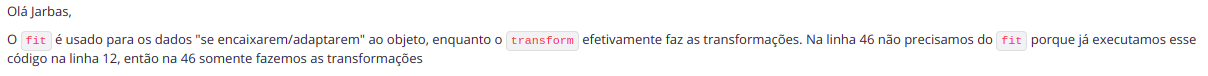

In [21]:
X_test = []
# Colocar 0:6, agora com mais atributos previsores
for i in range(90,112):
    X_test.append(entradas[i-90:i, 0:6])
    

X_test = np.array(X_test)

In [22]:
# Não vamos precisar executar o código abaixo
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
previsoes = regressor.predict(X_test)

###### Executando """ previsoes = normalizador.inverse_transform(previsoes) """" dará um erro pois a base_treinamento_normalizada está em um dimensão diferente, pois pegamos 6 atributos para previsão, quando nos exemplos anteriores era apenas um atributo, o que resultaria na mesma dimensão da saída que agora não seria o caso. 

###### Logo, precisamos criar outra variavél, como abaixo, para deixarmos os dados a serem preditos da base de treinamento na mesma dimensão das previsões:

##### normalizador_previsao = MinMaxScaler(feature_range(0,1)) 
##### normalizador.previsao.fit_transform(base_treinamento[:,0:1])

In [30]:
base_treinamento[:,0:1]

array([[19.99    ],
       [19.809999],
       [20.33    ],
       ...,
       [15.99    ],
       [16.1     ],
       [16.1     ]])

In [24]:
normalizador_previsao = MinMaxScaler(feature_range=(0,1)) 
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [25]:
# Pode-se comparar cada previsao com o respectivo preço real
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [26]:
previsoes.mean()

17.874622

In [27]:
preco_real_teste.mean()

17.87454563636364

In [28]:
diferença_media = 17.876564 - 17.87454563636364
diferença_media

0.0020183636363597657

# GRÁFICO DAS AÇÕES

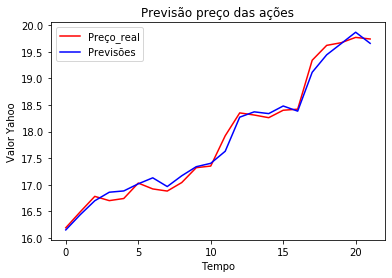

In [29]:
plt.plot(preco_real_teste, color='red', label='Preço_real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()